# Posterior uncertainties

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import ivpsolve, recipes

config.update("jax_enable_x64", True)
backend.select("jax")

In [2]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()


@jax.jit
def vf(t, *ys):
    return f(*ys, *f_args)

In [3]:
# Low resolution to achieve large uncertainty
ek0 = recipes.dynamic_isotropic_fixpt_eks0(num_derivatives=1, rtol=1e-1, atol=1e-1)

In [4]:
ts = jnp.linspace(t0, t0 + 2.0, endpoint=True, num=500)
solution = ivpsolve.simulate_checkpoints(vf, initial_values=(u0,), ts=ts, solver=ek0)
assert jnp.allclose(solution.t, ts)

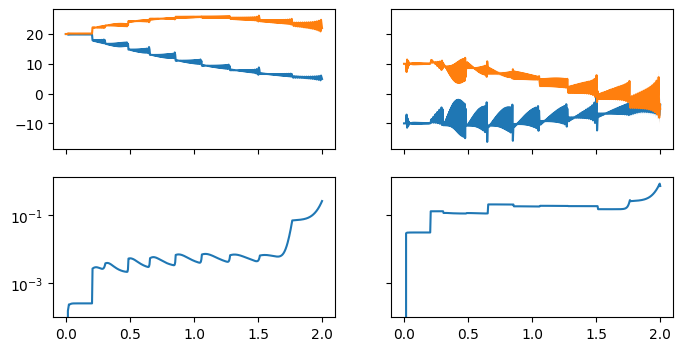

In [5]:
_, nums, _ = solution.filtered.mean.shape

fig, axes_all = plt.subplots(
    nrows=2, ncols=nums, sharex=True, sharey="row", figsize=(8, 4)
)

for axes, i in zip(axes_all.T, range(nums)):
    ms = solution.filtered.mean[:, i, :]
    ls = solution.filtered.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    axes[0].plot(solution.t, ms)
    for m in ms.T:
        axes[0].fill_between(solution.t, m - 3 * stds, m + 3 * stds, alpha=0.3)

    axes[1].semilogy(solution.t, stds)

plt.show()